# A closer look at Tosato's classification data

While browsing through the datasets, I found some weird things that I'll investigate in this notebook. I'll also have a look at some basic dataset statistics.

In [1]:
import numpy as np
import cv2
import json
from os.path import join as pjoin
from IPython.display import HTML, display, clear_output
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import sklearn.preprocessing as skpp

In [3]:
%matplotlib inline

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
import lbtoolbox.plotting as lbplt

# Load the data

In [5]:
datadir = './data/'
datafiles = {
    'QMUL': 'QMULPoseHeads.json',
    'Coffee': 'HOCoffee.json',
    'ETH': 'HOC.json',
    'HIIT': 'HIIT6HeadPose.json',
}

In [6]:
def loadfiles(data, basename, subsample=None):
    def myloadim(fname):
        im = cv2.imread(fname, flags=cv2.IMREAD_COLOR)
        if im is None:
            raise IOError("Couldn't load image " + fname)
        # In OpenCV, color dimension is last, but theano likes it to be first.
        # (That's map of triplets vs three maps philosophy.)
        # Also convert BGR to RGB while we're at it. Not that it makes any difference.
        return np.rollaxis(im[:,:,::-1], 2, 0).astype(np.float32)

    return zip(*[[myloadim(pjoin(basename, name)), lbl, name] for lbl, files in data.items() for name in files if subsample is None or np.random.rand() < subsample])

def loadall(datadir, datafiles, **kw):
    Xtr, Xte = {}, {}
    ytr, yte = {}, {}
    ntr, nte = {}, {}
    le = {}

    for name, fname in datafiles.items():
        files = json.load(open(pjoin(datadir, fname)))
        tr_imgs, tr_lbls, tr_names = loadfiles(files['train'], datadir, **kw)
        te_imgs, te_lbls, te_names = loadfiles(files['test'], datadir, **kw)

        le[name] = skpp.LabelEncoder().fit(tr_lbls)
        Xtr[name] = np.array(tr_imgs)/255
        Xte[name] = np.array(te_imgs)/255
        ytr[name] = le[name].transform(tr_lbls).astype(np.int32)
        yte[name] = le[name].transform(te_lbls).astype(np.int32)
        ntr[name] = tr_names
        nte[name] = te_names

    return Xtr, Xte, ytr, yte, ntr, nte, le

Xtr, Xte, ytr, yte, ntr, nte, le = loadall(datadir, datafiles)

In [7]:
for k, v in Xtr.items():
    print("{}: train {} {}(range {})".format(k, v.shape, v.dtype, np.ptp(v)))
print("---")
for k, v in Xte.items():
    print("{}: test {} {}(range {})".format(k, v.shape, v.dtype, np.ptp(v)))

QMUL: train (11280, 3, 50, 50) float32(range 1.0)
HIIT: train (12000, 3, 50, 50) float32(range 1.0)
ETH: train (6860, 3, 132, 62) float32(range 1.0)
Coffee: train (9522, 3, 50, 50) float32(range 1.0)
---
QMUL: test (8725, 3, 50, 50) float32(range 1.0)
HIIT: test (12007, 3, 50, 50) float32(range 1.0)
ETH: test (5021, 3, 132, 62) float32(range 1.0)
Coffee: test (8595, 3, 50, 50) float32(range 1.0)


# QMUL

## Label distribution

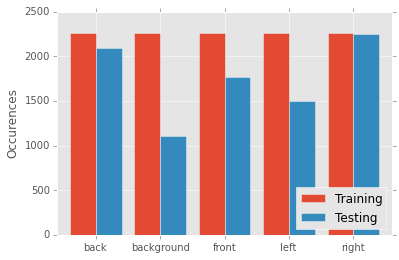

In [8]:
from collections import Counter
f, _ = lbplt.showcounts(Counter(le['QMUL'].inverse_transform(ytr['QMUL'])),
                  Counter(le['QMUL'].inverse_transform(yte['QMUL'])), labels=('Training', 'Testing'),
                  percent=False, legendkw={'loc': 'lower right'})

## What's with 'xx - Copy.jpg'?

In [9]:
sorted(ntr['QMUL'])[:10]

['QMULPoseHeads/train/Data_b/000032.jpg',
 'QMULPoseHeads/train/Data_b/000059.jpg',
 'QMULPoseHeads/train/Data_b/000065.jpg',
 'QMULPoseHeads/train/Data_b/000068 - Copy.jpg',
 'QMULPoseHeads/train/Data_b/000068.jpg',
 'QMULPoseHeads/train/Data_b/000072.jpg',
 'QMULPoseHeads/train/Data_b/000076.jpg',
 'QMULPoseHeads/train/Data_b/000084.jpg',
 'QMULPoseHeads/train/Data_b/000086 - Copy.jpg',
 'QMULPoseHeads/train/Data_b/000086.jpg']

0.0


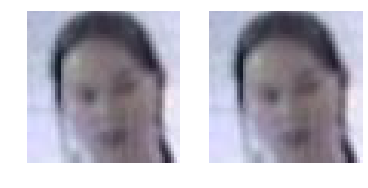

In [10]:
fig, axes = lbplt.subplotgrid_for(2, axis=False)
a = Xtr['QMUL'][ntr['QMUL'].index('QMULPoseHeads/train/Data_f/001633.jpg')]
b = Xtr['QMUL'][ntr['QMUL'].index('QMULPoseHeads/train/Data_f/001633 - Copy.jpg')]
lbplt.imshow(a, colordim=0, ax=axes[0])
lbplt.imshow(b, colordim=0, ax=axes[1])
print(np.max(np.abs(a-b)))

In [11]:
def checkdubs(names, X, hint):
    ncopy = 0
    for i, name in enumerate(names):
        if hint in name:
            try:
                iother = names.index(name.replace(hint, ''))
            except ValueError:
                continue

            ncopy += 1
            delta = np.max(np.abs(X[i]-X[iother]))
            if delta > 0.0:
                print('{}: {}'.format(name, delta))
    print('Total of {} copies, of which only the above (if any) differ.'.format(ncopy))

checkdubs(ntr['QMUL'], Xtr['QMUL'], hint=' - Copy')
checkdubs(nte['QMUL'], Xte['QMUL'], hint=' - Copy')

Total of 1467 copies, of which only the above (if any) differ.
Total of 0 copies, of which only the above (if any) differ.


## What's with 'xx_f'?

In [12]:
checkdubs(ntr['QMUL'], Xtr['QMUL'], hint='_f')
checkdubs(nte['QMUL'], Xte['QMUL'], hint='_f')

Total of 0 copies, of which only the above (if any) differ.
Total of 0 copies, of which only the above (if any) differ.


So it looks like those guys aren't duplicates, at least not by filename.

## Do exhaustive search for flips

### Within `front`, `back` or `background` classes

In [13]:
def flipdists_within(X, y, lbl):
    indices = np.where(y == lbl)[0]

    n = len(indices)
    flipdists = np.full((n,n), -1)

    progress = widgets.IntProgressWidget(value=0, min=0, max=n, description='Computing {:.2f}M flipdists:'.format(n*(n-1)/2/1000/1000))
    display(progress)

    for i, idx1 in enumerate(indices):
        for j, idx2 in enumerate(indices[i:]):
            j += i
            flipdists[i,j] = flipdists[j,i] = np.mean(np.abs(X[idx1] - np.fliplr(X[idx2])))
        progress.value += 1
    return flipdists

In [14]:
flipdists_front = flipdists_within(Xtr['QMUL'], ytr['QMUL'], le['QMUL'].transform('front'))
np.sum(flipdists_front < 0.01)

0

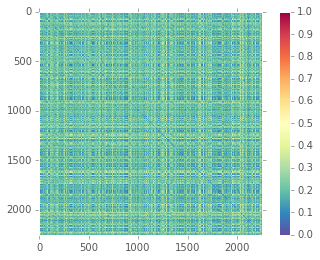

In [15]:
ax = lbplt.imshow(flipdists_front, vmin=0, vmax=1)

In [16]:
flipdists_back = flipdists_within(Xtr['QMUL'], ytr['QMUL'], le['QMUL'].transform('back'))
np.sum(flipdists_back < 0.01)

0

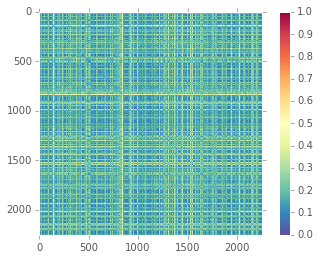

In [17]:
ax = lbplt.imshow(flipdists_back, vmin=0, vmax=1)

In [18]:
flipdists_background = flipdists_within(Xtr['QMUL'], ytr['QMUL'], le['QMUL'].transform('background'))
np.sum(flipdists_background < 0.01)

0

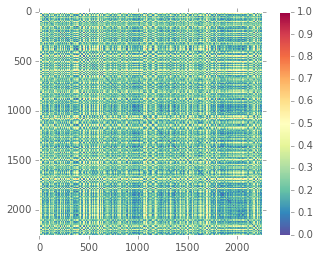

In [19]:
ax = lbplt.imshow(flipdists_background, vmin=0, vmax=1)

Looks like there's no (almost) perfect flip.

### Across `left` and `right` classes

In [20]:
def flipdists_across(X, y, lbl1, lbl2):
    indices1 = np.where(y == lbl1)[0]
    indices2 = np.where(y == lbl2)[0]

    n1, n2 = len(indices1), len(indices2)
    flipdists = np.full((n1,n2), -1)

    progress = widgets.IntProgressWidget(value=0, min=0, max=n1, description='Computing {:.2f}M flipdists:'.format(n1*n2/1000/1000))
    display(progress)

    for i, idx1 in enumerate(indices1):
        for j, idx2 in enumerate(indices2):
            flipdists[i,j] = np.mean(np.abs(X[idx1] - np.fliplr(X[idx2])))
        progress.value += 1
    return flipdists

In [21]:
flipdists_lr = flipdists_across(Xtr['QMUL'], ytr['QMUL'], le['QMUL'].transform('left'), le['QMUL'].transform('right'))

In [22]:
np.sum(flipdists_lr < 0.01)

0

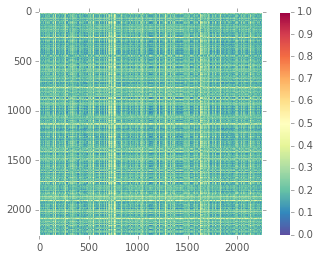

In [23]:
ax = lbplt.imshow(flipdists_lr, vmin=0, vmax=1)

# Coffee

## Label distribution

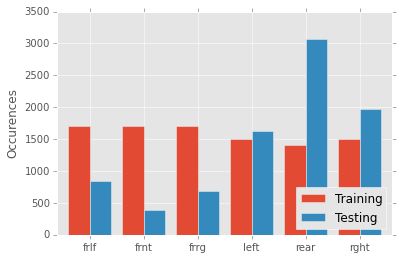

In [24]:
from collections import Counter
f, _ = lbplt.showcounts(Counter(le['Coffee'].inverse_transform(ytr['Coffee'])),
                  Counter(le['Coffee'].inverse_transform(yte['Coffee'])), labels=('Training', 'Testing'),
                  percent=False, legendkw={'loc': 'lower right'})

## What's with jpg vs png?

In [25]:
sorted(ntr['Coffee'])[:10]

['HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (1).jpg',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (1).png',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (10).jpg',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (10).png',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (100).jpg',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (100).png',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (1000).png',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (1001).png',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (1002).png',
 'HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (1003).png']

0.209294


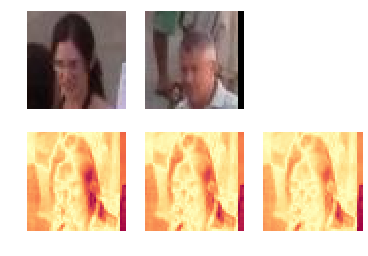

In [26]:
fig, axes = lbplt.subplotgrid_for(6, axis=False)
a = Xtr['Coffee'][ntr['Coffee'].index('HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (4).jpg')]
b = Xtr['Coffee'][ntr['Coffee'].index('HOCoffee/Coffebreak6HeadPose/train/Data_frlf/head (4).png')]
lbplt.imshow(a, colordim=0, ax=axes[0,0])
lbplt.imshow(b, colordim=0, ax=axes[0,1])
lbplt.imshow(np.abs(a-b)[0], ax=axes[1,0])
lbplt.imshow(np.abs(a-b)[1], ax=axes[1,1])
lbplt.imshow(np.abs(a-b)[2], ax=axes[1,2])
print(np.mean(np.abs(a-b)))

In [27]:
def checkdubs2(names, X):
    ncopy = 0
    for i, name in enumerate(names):
        if name.endswith('.jpg'):
            try:
                iother = names.index(name.replace('.jpg', '.png'))
            except ValueError:
                continue

            ncopy += 1
            delta = np.max(np.abs(X[i]-X[iother]))
            if delta < 0.01:
                print('{}: {}'.format(name, delta))
    print('Total of {} copies, of which only the above (if any) are the same.'.format(ncopy))

checkdubs2(ntr['Coffee'], Xtr['Coffee'])

Total of 2375 copies, of which only the above (if any) are the same.


So it seems none of the two are the same!

## Do exhaustive search for flips

In [28]:
le['Coffee'].classes_

array(['frlf', 'frnt', 'frrg', 'left', 'rear', 'rght'], 
      dtype='<U4')

### Within `frnt` or `rear` classes

0

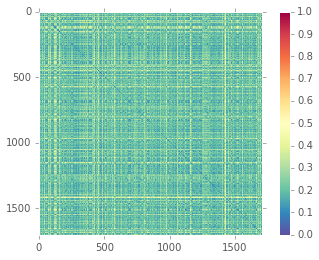

In [29]:
flipdists_front = flipdists_within(Xtr['Coffee'], ytr['Coffee'], le['Coffee'].transform('frnt'))
ax = lbplt.imshow(flipdists_front, vmin=0, vmax=1)
np.sum(flipdists_front < 0.01)

0

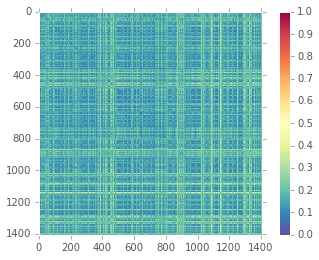

In [30]:
flipdists_rear = flipdists_within(Xtr['Coffee'], ytr['Coffee'], le['Coffee'].transform('rear'))
ax = lbplt.imshow(flipdists_rear, vmin=0, vmax=1)
np.sum(flipdists_rear < 0.01)

### Across `left` and `rght`, and `frlf` and `frrg` classes

0

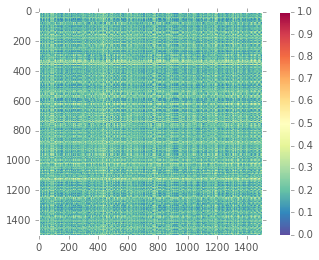

In [31]:
flipdists_lr = flipdists_across(Xtr['Coffee'], ytr['Coffee'], le['Coffee'].transform('left'), le['Coffee'].transform('rght'))
ax = lbplt.imshow(flipdists_lr, vmin=0, vmax=1)
np.sum(flipdists_lr < 0.01)

0

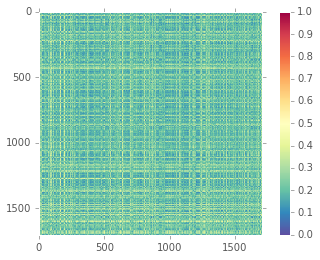

In [32]:
flipdists_flr = flipdists_across(Xtr['Coffee'], ytr['Coffee'], le['Coffee'].transform('frlf'), le['Coffee'].transform('frrg'))
ax = lbplt.imshow(flipdists_flr, vmin=0, vmax=1)
np.sum(flipdists_flr < 0.01)

# ETH

## Label distribution

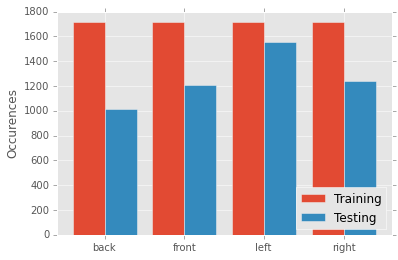

In [33]:
from collections import Counter
f, _ = lbplt.showcounts(Counter(le['ETH'].inverse_transform(ytr['ETH'])),
                  Counter(le['ETH'].inverse_transform(yte['ETH'])), labels=('Training', 'Testing'),
                  percent=False, legendkw={'loc': 'lower right'})

## Just checkin that `(#)` stuff in testset

In [34]:
sorted(nte['ETH'])[15:25]

['HOC/ETHZ4HumanPose/test/Test_b/norm_0001033.jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0001035.jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002001 (3).jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002002 (3).jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002002.jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002003 (3).jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002004 (2).jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002004.jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002005 (3).jpg',
 'HOC/ETHZ4HumanPose/test/Test_b/norm_0002006 (2).jpg']

0.24421


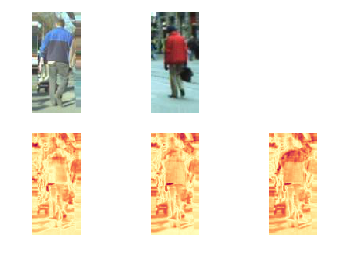

In [35]:
fig, axes = lbplt.subplotgrid_for(6, axis=False)
a = Xte['ETH'][nte['ETH'].index('HOC/ETHZ4HumanPose/test/Test_b/norm_0002002 (3).jpg')]
b = Xte['ETH'][nte['ETH'].index('HOC/ETHZ4HumanPose/test/Test_b/norm_0002002.jpg')]
lbplt.imshow(a, colordim=0, ax=axes[0,0])
lbplt.imshow(b, colordim=0, ax=axes[0,1])
lbplt.imshow(np.abs(a-b)[0], ax=axes[1,0])
lbplt.imshow(np.abs(a-b)[1], ax=axes[1,1])
lbplt.imshow(np.abs(a-b)[2], ax=axes[1,2])
print(np.mean(np.abs(a-b)))

## Do exhaustive search for flips

### Within `front` or `back` classes

0

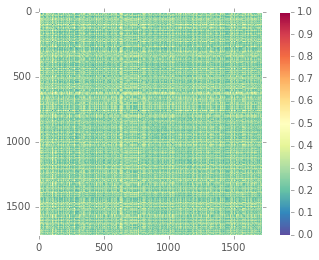

In [36]:
flipdists_front = flipdists_within(Xtr['ETH'], ytr['ETH'], le['ETH'].transform('front'))
ax = lbplt.imshow(flipdists_front, vmin=0, vmax=1)
np.sum(flipdists_front < 0.01)

0

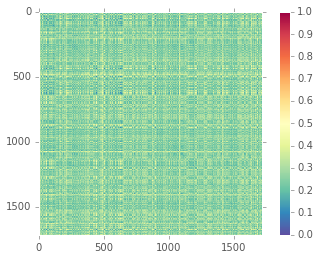

In [37]:
flipdists_back = flipdists_within(Xtr['ETH'], ytr['ETH'], le['ETH'].transform('back'))
ax = lbplt.imshow(flipdists_back, vmin=0, vmax=1)
np.sum(flipdists_back < 0.01)

### Across `left` and `right` classes

0

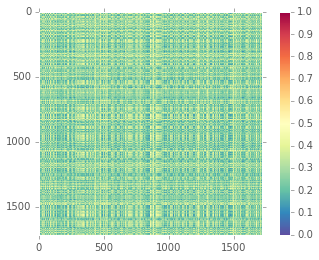

In [38]:
flipdists_lr = flipdists_across(Xtr['ETH'], ytr['ETH'], le['ETH'].transform('left'), le['ETH'].transform('right'))
ax = lbplt.imshow(flipdists_lr, vmin=0, vmax=1)
np.sum(flipdists_lr < 0.01)

# HIIT

## Label distribution

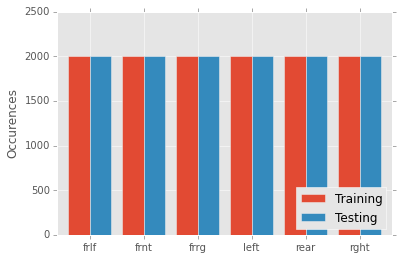

In [39]:
from collections import Counter
f, _ = lbplt.showcounts(Counter(le['HIIT'].inverse_transform(ytr['HIIT'])),
                  Counter(le['HIIT'].inverse_transform(yte['HIIT'])), labels=('Training', 'Testing'),
                  percent=False, legendkw={'loc': 'lower right'})

## Do exhaustive search for flips

In [40]:
le['Coffee'].classes_

array(['frlf', 'frnt', 'frrg', 'left', 'rear', 'rght'], 
      dtype='<U4')

### Within `frnt` or `rear` classes

0

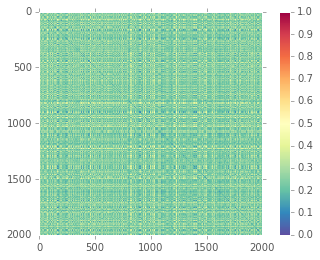

In [41]:
flipdists_front = flipdists_within(Xtr['HIIT'], ytr['HIIT'], le['HIIT'].transform('frnt'))
ax = lbplt.imshow(flipdists_front, vmin=0, vmax=1)
np.sum(flipdists_front < 0.01)

0

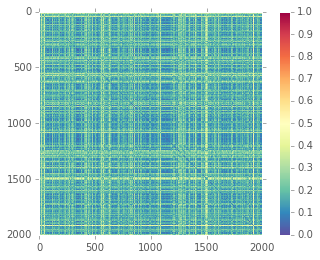

In [42]:
flipdists_rear = flipdists_within(Xtr['HIIT'], ytr['HIIT'], le['HIIT'].transform('rear'))
ax = lbplt.imshow(flipdists_rear, vmin=0, vmax=1)
np.sum(flipdists_rear < 0.01)

### Across `left` and `rght`, and `frlf` and `frrg` classes

0

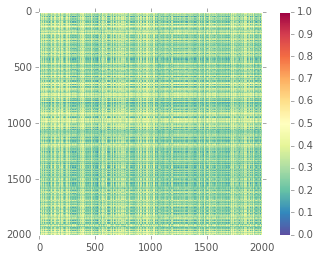

In [43]:
flipdists_lr = flipdists_across(Xtr['HIIT'], ytr['HIIT'], le['HIIT'].transform('left'), le['HIIT'].transform('rght'))
ax = lbplt.imshow(flipdists_lr, vmin=0, vmax=1)
np.sum(flipdists_lr < 0.01)

0

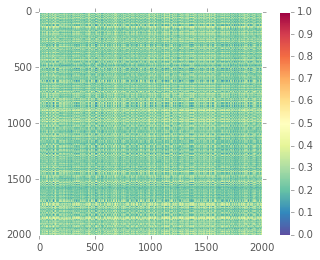

In [44]:
flipdists_flr = flipdists_across(Xtr['HIIT'], ytr['HIIT'], le['HIIT'].transform('frlf'), le['HIIT'].transform('frrg'))
ax = lbplt.imshow(flipdists_flr, vmin=0, vmax=1)
np.sum(flipdists_flr < 0.01)